# WP12

## Theoretical Methods for Condensed Matter

### Tom Frömbgen

# Part III

# Solid-state calculations with the CRYSTAL code
---
## General Setup

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import lmfit as lf
from lmfit.models import ExpressionModel
from inspect import signature
#from scipy.optimize import curve_fit
#from scipy.optimize import differential_evolution as DE
import os
import sys
import linecache
from pathlib import Path
from IPython.display import display_html, display
from itertools import chain, cycle


save_as_pgf = 1
save_as_png = 0

if save_as_pgf == 1:
    mpl.use("pgf")
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['pgf.texsystem'] = 'pdflatex'
    mpl.rcParams['pgf.rcfonts'] = False
    mpl.rcParams['pgf.preamble'] = r'\usepackage{amssymb} \usepackage{amsmath}'
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['font.serif'] = 'Computer Modern'
    mpl.rc('axes', titlesize=10)     # fontsize of the axes title
    mpl.rc('axes', labelsize=10)     # fontsize of the x and y labels
    mpl.rc('xtick', labelsize=8)    # fontsize of the tick labels
    mpl.rc('ytick', labelsize=8)    # fontsize of the tick labels
    mpl.rc('legend', fontsize=8)
    mpl.rc('figure', titlesize=10)   # fontsize of the figure title

    lw = 1 # width of grid lines

    # width of tex document in inches
    fig_width = 6.69423
    fig_height = fig_width * 0.6
    #import matplotlib.pyplot as plt
    
else:
    #import matplotlib.pyplot as plt
    plt.rc('font', size=16)          # controls default text sizes
    plt.rc('axes', titlesize=16)     # fontsize of the axes title
    plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
    plt.rc('legend', fontsize=18)    # legend fontsize
    plt.rc('figure', titlesize=18)   # fontsize of the figure title

    lw = 1

    # height and width for nice print in jupyter notebook
    fig_width = 20
    fig_height = 10
    


# number of decimals printed in numpy stuff
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

# uni bonn colors
blue = "#07529a"
yellow = "#ffb90c"

# number of decimals
ytick_format = mpl.ticker.FormatStrFormatter('%.2f')

/usr/lib64/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Helpers

In [2]:
def save_plot_as_pgf(fig, path):
  if save_as_pgf == 1:
    fig.savefig(path, format="pgf")


def save_plot_as_png(fig, path):
  if save_as_png == 1:
    fig.savefig(path, format="png")


def checkForFaultyData(df):
  if df.isnull().sum().sum() != 0:
    df.dropna(how='any', inplace=True)
    print(df.isnull().sum())
    print("WARNING! Dropped some null values.")
  return df

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)
    
eh2kcal = 627.503 # kcal/mol
ev2kcal = 23.0609
eh2kj = 2625.5 # kj/mol
ev2kj = 96.4869
eh2ev =  	27.2107 
ev2eh = 0.0367502 
eh2j = 43.60E-19 # Joule

# Main part


# 5. Bulk Properties of NaCl


### Q2 Lattice parameter

In [3]:
def getFileList():
    filelist = []
    for file in sorted(Path("./ex1/opts").rglob("*.out")):
        filelist.append(file)

    if len(filelist) == 0:
        sys.exit("No '*data' files found.")

    return filelist


data = []
flist = getFileList()
a_exp = 5.5937 # experimental lattice parameter

for i, file in enumerate(flist):
    with open(file) as f:
        for j, line in enumerate(f):
            if "    TOTAL CPU TIME =" in line:
                time = float(line.split()[4]) / 60
            if "         A              B              C           ALPHA      BETA       GAMMA" in line:
                a = float(next(f).split()[0])
                a_dev = ((a / a_exp) - 1) * 100

    func = str(file.parent).split("/")[2]
    method = func.upper().replace("_", "/")
    data.append([method, round(time, 2), round(a, 3), round(a_dev, 2)])
  
cols = ["Functional", "CPU time / mins", "a / Angstrom", "delta a / %"]
df = pd.DataFrame(columns=cols, data=data)
display(df)

# save to csv
save_loc = os.path.join(os.path.realpath("."), "ex1/nacl-relax.csv")
df.to_csv(save_loc, index=False)

,Functional,CPU time / mins,a / Angstrom,delta a / %
0,LDA/VWN,3.04,5.410,-3.28
1,M06L,3.12,5.492,-1.82
2,PBE0,16.20,5.573,-0.37
3,PWGGA,3.26,5.614,0.37


### Q3 Atomization energy

In [4]:
file = "ex1/atom/nacl/input.30792.out"
with open(file) as f:
    for j, line in enumerate(f):
        if "* OPT END - CONVERGED * E(AU):" in line:
            e_nacl = float(line.split()[7])

file = "ex1/atom/na3/input.18000.out"
with open(file) as f:
    for j, line in enumerate(f):
        if "== SCF ENDED - CONVERGENCE ON ENERGY      E(AU)" in line:
            e_na = float(line.split()[8])

file = "ex1/atom/cl4/input.18218.out"
with open(file) as f:
    for j, line in enumerate(f):
        if "== SCF ENDED - CONVERGENCE ON ENERGY      E(AU)" in line:
            e_cl = float(line.split()[8])

e_atom = e_na + e_cl - e_nacl
data = []
data.append([round(e_na, 2), round(e_cl, 2), round(e_nacl, 2), round(e_atom * eh2kj,2)])
df = pd.DataFrame(columns=["Na / Hartree", "Cl", "NaCl", "Atomization energy / kJ"], data=data)
display(df)

# save to csv
save_loc = os.path.join(os.path.realpath("."), "ex1/nacl-atomization.csv")
df.to_csv(save_loc, index=False)

,Na / Hartree,Cl,NaCl,Atomization energy / kJ
0,-162.17,-459.98,-622.39,623.34


### Q4 Band gap

In [5]:
def getFileList():
    filelist = []
    for file in sorted(Path("./ex1/bandgap").rglob("*.out")):
        filelist.append(file)

    if len(filelist) == 0:
        sys.exit("No '*data' files found.")

    return filelist

data = []
flist = getFileList()

for i, file in enumerate(flist):
    with open(file) as f:
        for j, line in enumerate(f):
            if "DIRECT ENERGY BAND GAP:" in line:
                bandgap = float(line.split()[4]) 
            if "ENERGY EXPRESSION=HARTREE+FOCK EXCH*" in line:
                test = line.split("*")[1]
                alpha = float(test.split("+")[0])
                epsilon = 1/alpha

    func = str(file.parent).split("/")[3]
    bas = str(file.parent).split("/")[2]
    method = func.upper()+"/"+bas.upper().replace("M", "m")
    data.append([method, round(bandgap,2), round(alpha,2), round(epsilon,2)])
  
cols = ["Method", "Bandgap / eV", "Fock-exchange / %", "Epsilon"]
df = pd.DataFrame(columns=cols, data=data)
display(df)

# save to csv
save_loc = os.path.join(os.path.realpath("."), "ex1/nacl-bandgaps.csv")
df.to_csv(save_loc, index=False)

,Method,Bandgap / eV,Fock-exchange / %,Epsilon
0,PBE0/mTZVP,7.28,0.25,4.00
1,PBE0-OPT/mTZVP,8.89,0.49,2.05
2,PBE0/POB-TZVP,7.66,0.25,4.00
3,PBE0-OPT/POB-TZVP,9.51,0.46,2.18
4,PW1PW/POB-TZVP,7.23,0.20,5.00
5,PW1PW-OPT/POB-TZVP,9.50,0.46,2.19


### Q5 Projected density of states (PDOS)

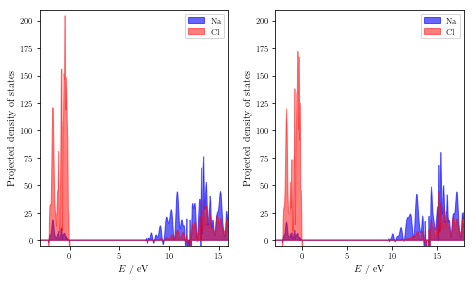

In [19]:
std = pd.read_csv("./ex1/dos/stand/DOSS.DAT", delim_whitespace=True)
opt = pd.read_csv("./ex1/dos/optimal/DOSS.DAT", delim_whitespace=True)

num_vert_plots = 1
num_hor_plots = 2
fig, ax = plt.subplots(num_vert_plots, num_hor_plots, figsize=(fig_width, fig_height))

x_std = std["EFERMI(Eh)"] * eh2ev
x_opt = opt["EFERMI(Eh)"] * eh2ev
names = ["Na", "Cl"]
colors = ["b", "r"]
alphas = [0.6, 0.5]
for i, name in enumerate(names): 
      y = std[name]
      ax[0].fill_between(x_std, y, color=colors[i], alpha=alphas[i], label=names[i])
      ax[0].set_xlabel(r"$E$ / eV")
      ax[0].set_ylabel(r"Projected density of states")
      ax[0].set_xlim(-3,16)
      ax[0].set_ylim(-5,210)
      ax[0].legend(loc="best", fancybox=True)

for i, name in enumerate(names): 
      y = opt[name]
      ax[1].fill_between(x_opt, y, color=colors[i], alpha=alphas[i], label=names[i])
      ax[1].set_xlabel(r"$E$ / eV")
      ax[1].set_ylabel(r"Projected density of states")
      ax[1].set_xlim(-3,18)
      ax[1].set_ylim(-5,210)
      ax[1].legend(loc="best", fancybox=True)

fig.tight_layout()
save_plot_as_pgf(fig, "protocol/Graphen/pdos.pgf")
plt.show()


# 6. Calculating Surfaces of TiO2


### Q7 Lattice parameters and fractional coordinates

In [20]:
def getFileList():
    filelist = []
    for file in sorted(Path("./ex2/opt").rglob("*.out")):
        filelist.append(file)

    if len(filelist) == 0:
        sys.exit("No '*data' files found.")

    return filelist


data = []
flist = getFileList()
a_exp = 4.593 # experimental lattice parameter
c_exp = 2.959 # experimental lattice parameter
for i, file in enumerate(flist):
    with open(file) as f:
        for line in f:
            if "    TOTAL CPU TIME =" in line:
                time = float(line.split()[4]) / 60
            if "         A              B              C           ALPHA      BETA       GAMMA" in line:
                test = next(f)
                a = float(test.split()[0])
                a_dev = ((a / a_exp) - 1)*100 
                c = float(test.split()[2])
                c_dev = ((c / c_exp) - 1)*100
            if "      3 T   8 O     3" in line:
                ofrac = float(line.split()[4])

    func = str(file.parent).split("/")[3]
    bas = str(file.parent).split("/")[2]
    method = func.upper()+"/"+bas
    data.append([method, round(time, 2), round(a,3), round(a_dev, 2), round(c, 3), round(c_dev, 2), round(ofrac, 4)])
  
cols = ["Method", "CPU time / mins", "a / Angstrom", "delta a / %", "c / Angstrom", "delta c / %", "xfrac(O)"]
df = pd.DataFrame(columns=cols, data=data)
display(df)

# save to csv
save_loc = os.path.join(os.path.realpath("."), "ex2/tio2-relax.csv")
df.to_csv(save_loc, index=False)

,Method,CPU time / mins,a / Angstrom,delta a / %,c / Angstrom,delta c / %,xfrac(O)
0,PBE0/rev2,344.76,4.578,-0.33,2.951,-0.28,0.3050
1,PBESOL/rev2,19.01,4.589,-0.08,2.946,-0.42,0.3042
2,PW1PW/rev2,328.13,4.585,-0.18,2.953,-0.20,0.3049
3,PWGGA/rev2,57.42,4.634,0.89,2.969,0.34,0.3048
4,PBE0/std,184.25,4.565,-0.62,2.981,0.74,0.3044
5,PBESOL/std,13.97,4.577,-0.35,2.970,0.39,0.3036
6,PW1PW/std,219.18,4.571,-0.47,2.982,0.77,0.3043
7,PWGGA/std,23.77,4.617,0.51,2.993,1.16,0.3041


### Q9 Single point energies of largest surface models with PW1PW

In [8]:
def getFileList():
    filelist = []
    for file in sorted(Path("./ex2/slab/pbesol-rev2/").rglob("*/8/single/*.out")):
        filelist.append(file)

    if len(filelist) == 0:
        sys.exit("No '*data' files found.")

    return filelist


data = []
flist = getFileList()
for i, file in enumerate(flist):
    with open(file) as f:
        for line in f:
            if "== SCF ENDED - CONVERGENCE ON ENERGY      E(AU)" in line:
                esurf = float(line.split()[8])

    surface = str(file.parent).split("/")[3]
    data.append([surface, esurf])
  
cols = ["Surface", "Energy / Eh"]
df = pd.DataFrame(columns=cols, data=data)
display(df)

# save to csv
save_loc = os.path.join(os.path.realpath("."), "ex2/pw1pw-energies.csv")
df.to_csv(save_loc, index=False)

,Surface,Energy / Eh
0,001,-8001.398182
1,100,-14002.631814
2,101,-14002.543316
3,110,-14002.626850


### Q11 Relaxation of symmetry-inequivalent atoms of the (110) surface in z-direction


#### Atoms in the topmost layer

In [9]:
def getFileList110():
    filelist = []
    for file in sorted(Path("./ex2/slab/pbesol-rev2/110/").rglob("[2-8]/*.out")):
        filelist.append(file)

    if len(filelist) == 0:
        sys.exit("No '*data' files found.")

    return filelist

flist = getFileList110()
numbers = []
for i, file in enumerate(flist):
    lines = []
    with open(file) as f:
        for i, line in enumerate(f):
            if " CARTESIAN COORDINATES - PRIMITIVE CELL" in line:
                for j in range(6):
                    line_number = i+j+4
                    lines.append(line_number)
        numbers.append(lines)

data = []
layers = [2, 3, 4, 5, 6, 7, 8]
for j, file in enumerate(flist):
    with open(file) as f:
        lines = []
        lines = f.readlines()
        dzo1 = float(lines[numbers[j][6]].split()[5]) - float(lines[numbers[j][0]].split()[5])
        dzti2 = float(lines[numbers[j][7]].split()[5]) - float(lines[numbers[j][1]].split()[5])
        dzti3 = float(lines[numbers[j][8]].split()[5]) - float(lines[numbers[j][2]].split()[5])
        
        data.append([layers[j], dzo1, dzti2, dzti3])
cols = ["n", "dz O1", "dz Ti2", "dz Ti3"]
df = pd.DataFrame(columns=cols, data=data)
display(df)

save_loc = os.path.join(os.path.realpath("."), "ex2/dz-surf.csv")
df.to_csv(save_loc, index=False)

,n,dz O1,dz Ti2,dz Ti3
0,2,0.097234,-0.276001,0.306425
1,3,-0.054968,-0.127168,0.129617
2,4,0.112712,-0.181779,0.314364
3,5,0.006534,-0.153865,0.201845
4,6,0.118204,-0.149283,0.318428
5,7,0.047190,-0.156752,0.245026
6,8,0.121364,-0.134949,0.321240


#### Bulk-like atoms

In [10]:
def getFileList110():
    filelist = []
    for file in sorted(Path("./ex2/slab/pbesol-rev2/110/").rglob("[3-8]/*.out")):
        filelist.append(file)

    if len(filelist) == 0:
        sys.exit("No '*data' files found.")

    return filelist

flist = getFileList110()
numbers = []
add = [0, 6, 6, 12, 12, 18, 18]
for k, file in enumerate(flist):
    lines = []
    with open(file) as f:
        for i, line in enumerate(f):
            if " CARTESIAN COORDINATES - PRIMITIVE CELL" in line:
                for j in range(6):
                    line_number = i+j+4+add[k]
                    lines.append(line_number)
        numbers.append(lines)

data = []
layers = [3, 4, 5, 6, 7, 8]
for j, file in enumerate(flist):
    with open(file) as f:
        lines = []
        lines = f.readlines()
        dzo1 = float(lines[numbers[j][6]].split()[5]) - float(lines[numbers[j][0]].split()[5])
        dzti2 = float(lines[numbers[j][7]].split()[5]) - float(lines[numbers[j][1]].split()[5])
        dzti3 = float(lines[numbers[j][8]].split()[5]) - float(lines[numbers[j][2]].split()[5])
        dzo4 = float(lines[numbers[j][9]].split()[5]) - float(lines[numbers[j][3]].split()[5])
        dzo5 = float(lines[numbers[j][10]].split()[5]) - float(lines[numbers[j][4]].split()[5])
        dzo6 = float(lines[numbers[j][11]].split()[5]) - float(lines[numbers[j][5]].split()[5])
        
        data.append([layers[j], dzo1, dzti2, dzti3, dzo4, dzo5, dzo6])
cols = ["n", "dz O1", "dz Ti2", "dz Ti3",  "dz O4", "dz O5", "dz O6"]
df = pd.DataFrame(columns=cols, data=data)
display(df)

save_loc = os.path.join(os.path.realpath("."), "ex2/dz-bulk.csv")
df.to_csv(save_loc, index=False)


,n,dz O1,dz Ti2,dz Ti3,dz O4,dz O5,dz O6
0,3,-0.054968,-0.127168,0.129617,0.176893,0.176893,-0.047729
1,4,-0.000414,0.261889,-0.148845,0.045470,0.045470,-0.023113
2,5,0.011790,0.112131,-0.070262,0.011928,0.011928,0.008064
3,6,0.053158,-0.157502,0.147781,0.007831,0.007831,0.042058
4,7,0.011983,-0.061648,0.053331,0.012149,0.012149,-0.002722
5,8,-0.016438,0.145781,-0.097107,0.017142,0.017142,-0.021586


#### Visualization

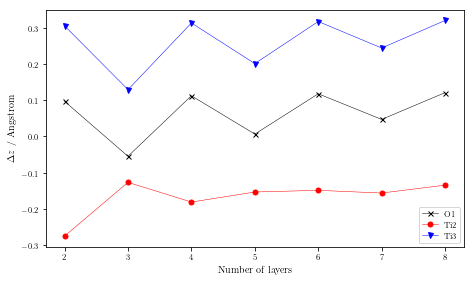

In [21]:
top = pd.read_csv("./ex2/dz-surf.csv", delimiter=",")
bulk = pd.read_csv("./ex2/dz-bulk.csv", delimiter=",")

num_vert_plots = 1
num_hor_plots = 1
fig, ax = plt.subplots(num_vert_plots, num_hor_plots, figsize=(fig_width, fig_height))

labels = ["O1", "Ti2", "Ti3"]
colors = ["k","r", "b"]
markers = ["x","o", "v"]
names = ["dz O1","dz Ti2","dz Ti3"]

for i, name in enumerate(names): 
      ax.plot(top["n"], top[name], color=colors[i], marker=markers[i], label=labels[i], markersize=5, lw=0.5)
      ax.set_xlabel("Number of layers")
      ax.set_ylabel(r"$\Delta z$ / Angstrom")
      ax.legend(loc="best", fancybox=True)

#labels = ["O1", "Ti2", "Ti3", "O4/5", "O6"]
#colors = ["k","r", "b", "g", "y"]
#markers = ["x","o", "v", "s", "p"]
#names = ["dz O1","dz Ti2", "dz Ti3", "dz O4","dz O6"]

#for i, name in enumerate(names): 
#      ax[1].plot(bulk["n"], bulk[name], color=colors[i], marker=markers[i], label=labels[i], markersize=5, lw=0.5)
#      ax[1].set_xlabel("Number of layers")
#      ax[1].set_ylabel(r"$\Delta z$ / Angstrom")
#      ax[1].legend(loc="best", fancybox=True)

fig.tight_layout()
save_plot_as_pgf(fig, "protocol/Graphen/dz.pgf")
plt.show()

### Q12 Surface energies for different slabs

#### Collecting data

In [12]:
def getFileList001():
    filelist = []
    for file in sorted(Path("./ex2/slab/pbesol-rev2/001/").rglob("[2-8]/*.out")):
        filelist.append(file)

    if len(filelist) == 0:
        sys.exit("No '*data' files found.")

    return filelist

def getFileList101():
    filelist = []
    for file in sorted(Path("./ex2/slab/pbesol-rev2/101/").rglob("[2-8]/*.out")):
        filelist.append(file)

    if len(filelist) == 0:
        sys.exit("No '*data' files found.")

    return filelist

def getFileList100():
    filelist = []
    for file in sorted(Path("./ex2/slab/pbesol-rev2/100/").rglob("[2-8]/*.out")):
        filelist.append(file)

    if len(filelist) == 0:
        sys.exit("No '*data' files found.")

    return filelist

def getFileList110():
    filelist = []
    for file in sorted(Path("./ex2/slab/pbesol-rev2/110/").rglob("[2-8]/*.out")):
        filelist.append(file)

    if len(filelist) == 0:
        sys.exit("No '*data' files found.")

    return filelist

data1 = []
data2 = []
data3 = []
data4 = []
data = [data1, data2, data3, data4]

surf1 = getFileList001()
surf2 = getFileList100()
surf3 = getFileList101()
surf4 = getFileList110()
surfaces = [surf1, surf2, surf3, surf4]

E_bulk = -1.996921376418E+03
factor = [0.5, 1, 1, 1]
for i, sf in enumerate(surfaces):
    for j, file in enumerate(sf):
        with open(file) as f:
            nlayer = float(str(file.parent).split("/")[4])
            for line in f:
                if "AREA OF THE 2D CELL" in line:
                    A = float(line.split()[5])
                if "* OPT END -" in line:
                    Eslab = float(line.split()[7])
            

        Esurf = (Eslab - nlayer * E_bulk * factor[i]) * eh2j * 10**20 / (2 * A)
        surface = str(file.parent).split("/")[3]
        data[i].append([surface, nlayer, A, round(Eslab, 3), round(Esurf,3)])
  
    cols = ["Surface", "n" ,"Area / Angstrom^2 ", "Slab Energy / Eh", "Surface Energy / J m^-2"]
    df1 = df2 = df3 = df4 = []
    df = [df1, df2, df3, df4]
    df[i] = pd.DataFrame(columns=cols, data=data[i])
    display(df[i])

    # save to csv
    file_names = ["ex2/surface-energy-001.csv", "ex2/surface-energy-100.csv", "ex2/surface-energy-101.csv", "ex2/surface-energy-110.csv"]
    save_loc = os.path.join(os.path.realpath("."), file_names[i])
    df[i].to_csv(save_loc, index=False)

,Surface,n,Area / Angstrom^2,Slab Energy / Eh,Surface Energy / J m^-2
0,001,2.0,21.061,-1996.846,0.780
1,001,3.0,21.061,-2995.165,2.242
2,001,4.0,21.061,-3993.724,1.229
3,001,5.0,21.061,-4992.119,1.907
4,001,6.0,21.061,-5990.633,1.356
5,001,7.0,21.061,-6989.058,1.730
6,001,8.0,21.061,-7987.549,1.411


,Surface,n,Area / Angstrom^2,Slab Energy / Eh,Surface Energy / J m^-2
0,100,2.0,13.522,-3993.786,0.917
1,100,3.0,13.522,-5990.707,0.925
2,100,4.0,13.522,-7987.628,0.928
3,100,5.0,13.522,-9984.549,0.930
4,100,6.0,13.522,-11981.470,0.932
5,100,7.0,13.522,-13978.392,0.935
6,100,8.0,13.522,-15975.313,0.940


,Surface,n,Area / Angstrom^2,Slab Energy / Eh,Surface Energy / J m^-2
0,101,2.0,25.028,-3993.717,1.096
1,101,3.0,25.028,-5990.605,1.384
2,101,4.0,25.028,-7987.547,1.203
3,101,5.0,25.028,-9984.460,1.276
4,101,6.0,25.028,-11981.388,1.221
5,101,7.0,25.028,-13978.308,1.237
6,101,8.0,25.028,-15975.231,1.219


,Surface,n,Area / Angstrom^2,Slab Energy / Eh,Surface Energy / J m^-2
0,110,2.0,19.123,-3993.798,0.514
1,110,3.0,19.123,-5990.683,0.929
2,110,4.0,19.123,-7987.632,0.608
3,110,5.0,19.123,-9984.539,0.776
4,110,6.0,19.123,-11981.472,0.642
5,110,7.0,19.123,-13978.386,0.722
6,110,8.0,19.123,-15975.314,0.653


#### Comparison with PW1PW

In [13]:
slab_001 = pd.read_csv("./ex2/surface-energy-001.csv", delimiter=",")
slab_100 = pd.read_csv("./ex2/surface-energy-100.csv", delimiter=",")
slab_101 = pd.read_csv("./ex2/surface-energy-101.csv", delimiter=",")
slab_110 = pd.read_csv("./ex2/surface-energy-110.csv", delimiter=",")
pw1pw = pd.read_csv("./ex2/pw1pw-energies.csv", delimiter=",")

e_bulk = -2.0003835257335E+03
data = []
models = [slab_001, slab_100, slab_101, slab_110]
factor = [0.5, 1, 1, 1]
pbesol_index = [6, 5, 5, 5]
pw1pw_index = [1.407, 0.845, 1.190, 0.590]
for i, model in enumerate(models):
    e_surf_pw1pw = pw1pw_index[i]
    e_surf_pbesol = model["Surface Energy / J m^-2"][6]
    surface = model["Surface"][0]
    data.append([surface, 8, round(e_surf_pbesol, 3), round(e_surf_pw1pw, 3)])

df = pd.DataFrame(columns=["Surface", "n", "E_PBESOL", "E_PW1PW"], data=data)
display(df)

save_loc = os.path.join(os.path.realpath("."), "ex2/pw1pw-compare.csv")
df.to_csv(save_loc, index=False)

,Surface,n,E_PBESOL,E_PW1PW
0,1,8,1.411,1.407
1,100,8,0.940,0.845
2,101,8,1.219,1.190
3,110,8,0.653,0.590


#### Plotting

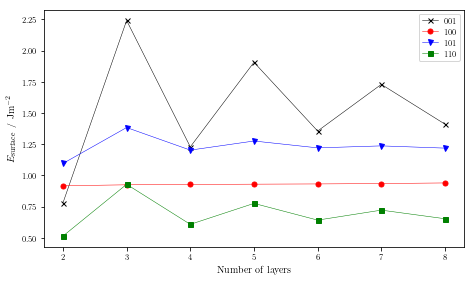

In [14]:
num_vert_plots = 1
num_hor_plots = 1
fig, ax = plt.subplots(num_vert_plots, num_hor_plots, figsize=(fig_width, fig_height))

names = [slab_001, slab_100, slab_101, slab_110]
labels = ["001", "100", "101", "110"]
colors = ["k","r", "b", "g"]
markers = ["x","o", "v", "s"]
for i, name in enumerate(names): 
      ax.plot(name["n"], name["Surface Energy / J m^-2"], lw = 0.5, color=colors[i], label=labels[i], marker=markers[i], markersize=5)
      ax.set_xlabel("Number of layers")
      ax.set_ylabel(r"$E_\mathrm{surface}$ / $\mathrm{Jm^{-2}}$")
      ax.legend(loc="best", fancybox=True)

fig.tight_layout()
save_plot_as_pgf(fig, "protocol/Graphen/slab.pgf")
plt.show()